In [1]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
from openslide import OpenSlide

Image.MAX_IMAGE_PIXELS = None

seed=0

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
class PathologyDataset(Dataset):
    def __init__(self, index_path='/home/rens/hpc/PREMIUM histopathology/data/index.csv', transform=None, dim=228, level=3):
        self.index = pd.read_csv(index_path).set_index('path')
        self.transform = transform
        self.dim = dim
        self.level = level

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        slide_path = self.index.iloc[idx]
        

        # select a random patch center based on the tumor mask
        mask = np.array(Image.open(mask_path))
        possible_centers = np.where(mask == 1)
        
        location_index = np.random.randint(0, len(possible_centers[0]))
        x,y = possible_centers[0][location_index], possible_centers[1][location_index]
        
        # read patch from WSI
        slide = OpenSlide(str(slide_path))
        magnification = slide.level_dimensions[0][0] / mask.shape[1]

        # convert to slide coordinates for top left corner
        y = int(y * magnification - self.dim/2)
        x = int(x * magnification - self.dim/2)

        # ensure the patch does not go out of bounds
        x,y = max(x, 0), max(y, 0)
        
        slide_dimensions = slide.level_dimensions[self.level]
        x = min(x, (slide_dimensions[1] - self.dim) * magnification)
        y = min(y, (slide_dimensions[0] - self.dim) * magnification)

        # extract patch
        patch = np.array(slide.read_region(
            (y,x), 
            level=self.level, 
            size=(self.dim,self.dim)
        ))[:,:,:3]

        # apply transforms
        patch = self.transform(patch)
        # todo: color normalization + color augmentation

        return patch

In [3]:
index = pd.read_csv('/home/rens/hpc/PREMIUM histopathology/data/index.csv').set_index('path')

In [6]:
from scipy.ndimage import zoom

class ThresholdROI():
    def __init__(self, threshold=550):
        self.threshold = threshold

    def __call__(self, path):
        slide = OpenSlide(path)

        img = np.array(slide.read_region(
            (0,0), 
            slide.level_count-2, 
            slide.level_dimensions[slide.level_count-2]
        ).convert('RGB'))

        mask = img.sum(axis=-1) < 550

        factor = slide.level_dimensions[0][0] / slide.level_dimensions[-2][0]

        # upsampled_mask = zoom(mask, factor, order=0, mode='nearest')

        return mask

In [7]:
troi = ThresholdROI()

mask = troi(index.index[0])

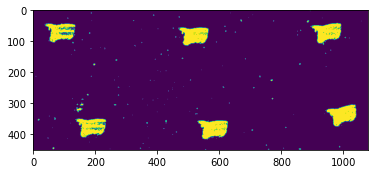

In [8]:
plt.imshow(mask)
plt.show()

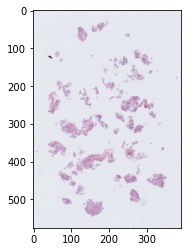

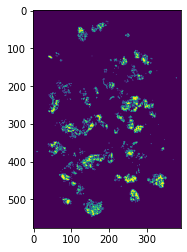

In [21]:
slide = OpenSlide(index.index[3])

img = np.array(slide.read_region(
    (0,0), 
    slide.level_count-2, 
    slide.level_dimensions[slide.level_count-2]
).convert('RGB'))

plt.imshow(img)
plt.show()

mask = img.sum(axis=-1) < 550

plt.imshow(mask)
plt.show()

In [22]:
mask.shape

(576, 390)

128.0